# --- Imports ---


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
import random

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# --- Load & Preprocess Dataset ---

In [2]:

df = pd.read_csv('Injury_Risk_Prep_Updated.csv')
df.drop(columns=['Player ID','Player'], inplace=True)
df['Season'] = df['Season'].apply(lambda x: int(x.split('/')[0]))
df['Date of Injury'] = pd.to_datetime(df['Date of Injury'])
df['Date of return'] = pd.to_datetime(df['Date of return'])
df['Days_until_return'] = (df['Date of return'] - df['Date of Injury']).dt.days
df.drop(columns=['Date of Injury', 'Date of return'], inplace=True)

y_classification = df['Injury_Grouped_Encoded'].astype(int)
df.drop(columns=['Injury_Grouped','Injury'], inplace=True)


In [3]:
# Normalize numeric columns

target_cols = ['Injury_Grouped_Encoded']
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col not in target_cols]
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# Train-test split
X_train_scaled, X_test_scaled, y_train_class_scaled, y_test_class_scaled = train_test_split(
    df_scaled, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)



In [4]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# --- Classification Models: XGBoost / Random Forest / ANN ---

In [5]:

# XGBoost
param_grid_class = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.1]
}
xgb_class = XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_classification)), random_state=42, use_label_encoder=False)
random_search_xgb = RandomizedSearchCV(xgb_class, param_distributions=param_grid_class, n_iter=10, scoring='accuracy', cv=5, random_state=42)
random_search_xgb.fit(X_train_scaled, y_train_class_scaled)
best_xgb_class = random_search_xgb.best_estimator_

# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}
rf_class = RandomForestClassifier(random_state=42)
random_search_rf = RandomizedSearchCV(rf_class, param_distributions=param_grid_rf, n_iter=10, scoring='accuracy', cv=5, random_state=42)
random_search_rf.fit(X_train_scaled, y_train_class_scaled)
best_rf_class = random_search_rf.best_estimator_

# ANN
model_ann = Sequential([
    Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dense(len(np.unique(y_train_class_scaled)), activation='softmax')
])
model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ann_history = model_ann.fit(X_train_scaled, y_train_class_scaled, epochs=50, batch_size=16, validation_split=0.2, verbose=0,
                            callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])


# --- Evaluation ---



XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00         3

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



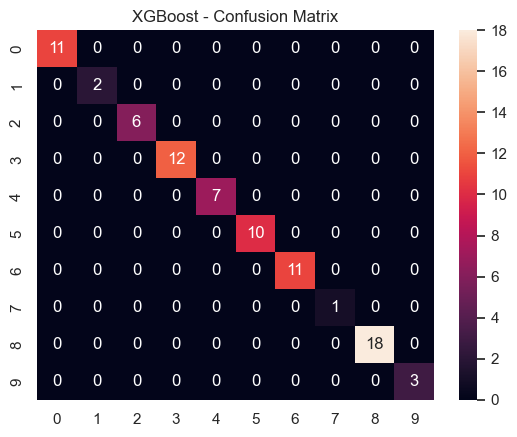


RandomForest Accuracy: 0.8765
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.33      0.50      0.40         2
           2       1.00      1.00      1.00         6
           3       0.92      1.00      0.96        12
           4       1.00      0.57      0.73         7
           5       0.82      0.90      0.86        10
           6       0.91      0.91      0.91        11
           7       0.00      0.00      0.00         1
           8       0.86      1.00      0.92        18
           9       1.00      0.33      0.50         3

    accuracy                           0.88        81
   macro avg       0.77      0.71      0.72        81
weighted avg       0.88      0.88      0.87        81



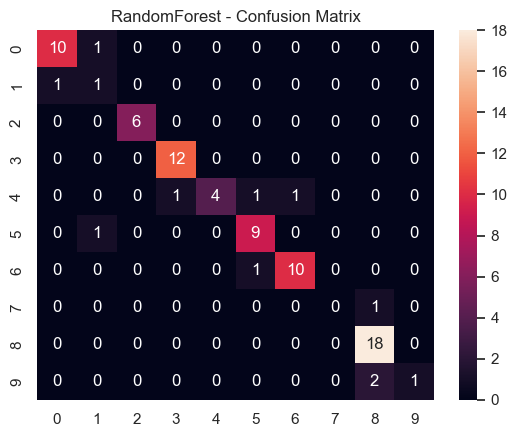

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

ANN Accuracy: 0.6296
              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.00      0.00      0.00         2
           2       0.22      0.33      0.27         6
           3       0.53      0.67      0.59        12
           4       0.60      0.43      0.50         7
           5       0.62      0.80      0.70        10
           6       0.67      0.73      0.70        11
           7       0.00      0.00      0.00         1
           8       0.86      1.00      0.92        18
           9       0.00      0.00      0.00         3

    accuracy                           0.63        81
   macro avg       0.45      0.43      0.42        81
weighted avg       0.64      0.63      0.61        81



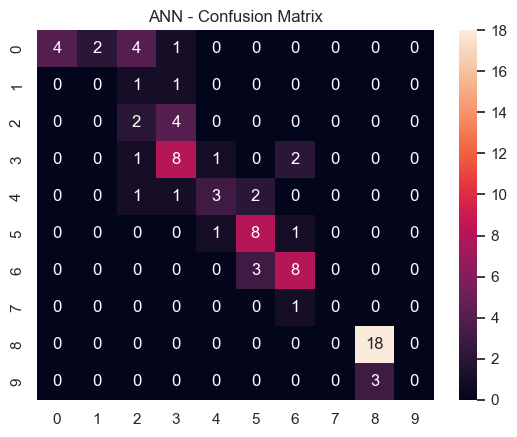

In [6]:

models_class = {
    'XGBoost': best_xgb_class,
    'RandomForest': best_rf_class,
    'ANN': model_ann
}

for name, model in models_class.items():
    if name == 'ANN':
        y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
        y_true = y_test_class_scaled
    elif name == 'XGBoost':
        y_pred = model.predict(X_test_scaled)
        y_true = y_test_class_scaled
    elif name == 'RandomForest':
        y_pred = model.predict(X_test_scaled)
        y_true = y_test_class_scaled

    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'{name} - Confusion Matrix')
    plt.show()


In [7]:
# --- Compare All Classification Models and Select Best ---
models_class = {
    'RandomForest': best_rf_class,
    'ANN': model_ann
    # 'XGBoost': best_xgb_class  # Excluded due to overfitting
}

best_class_model = None
best_class_score = 0
print("\n--- Classification Model Comparison ---")
for name, model in models_class.items():
    if name == 'ANN':
        y_pred = np.argmax(model.predict(X_test_scaled), axis=1)
        y_true = y_test_class_scaled
    elif name == 'RandomForest':
        y_pred = model.predict(X_test_scaled)
        y_true = y_test_class_scaled

    acc = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

    if acc > best_class_score:
        best_class_score = acc
        best_class_model = model




--- Classification Model Comparison ---
RandomForest Accuracy: 0.8765
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
ANN Accuracy: 0.6296


# --- Prediction for a Single Sample ---


In [8]:

simplified_injury_mapping = pd.read_csv('simplified_injury_mapping.csv')

if best_class_model == model_ann:
    sample_class = X_test_scaled.sample(n=1, random_state=random.randint(0, 10000))
    classification_pred = best_class_model.predict(sample_class)
    classification_pred = np.argmax(classification_pred, axis=1)
    classification_prob = best_class_model.predict(sample_class)
elif best_class_model == best_rf_class:
    rand_idx = random.randint(0, len(X_test_scaled) - 1)
    sample_class = X_test_scaled.iloc[[rand_idx]]
    classification_pred = best_class_model.predict(sample_class)
    classification_prob = best_class_model.predict_proba(sample_class)

top3_indices = np.argsort(classification_prob[0])[::-1][:3]
top3_probs = classification_prob[0][top3_indices]

print("\nTop 3 Predicted Injury Types:")
for idx, (i, prob) in enumerate(zip(top3_indices, top3_probs), start=1):
    injury_label = simplified_injury_mapping[simplified_injury_mapping['Encoded Value'] == i]['Injury Category'].values[0]
    print(f"{idx}. {injury_label} ({prob * 100:.2f}%)")



Top 3 Predicted Injury Types:
1. Ankle/Foot (73.14%)
2. Calf/Shin (11.22%)
3. General/Misc (4.15%)


In [9]:
importances = best_rf_class.feature_importances_
features = X_test_scaled.columns

# Create a DataFrame for better visibility
important_features_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(important_features_df.head(20))  # Top 20 features


                   Feature  Importance
9   Injury_Grouped_Encoded    0.431409
11       Days_until_return    0.100027
5     total_minutes_played    0.069839
10           fatigue_level    0.069226
6           matches_played    0.059566
3                      Age    0.058932
0              Nationality    0.056801
7       total_yellow_cards    0.043886
2                 Position    0.037623
1                Team_Name    0.035039
4                   Season    0.034567
8          total_red_cards    0.003085


In [10]:
print(df_scaled.shape)
print(df_scaled.head())


(402, 12)
   Nationality  Team_Name  Position       Age   Season  total_minutes_played  \
0     1.414354   1.381587 -1.037614  0.035967 -1.40873              0.417310   
1    -0.684085   1.381587 -1.037614  0.626116 -1.40873              0.635490   
2    -0.684085   1.381587 -1.037614  0.626116 -1.40873              0.635490   
3    -0.684085   1.381587 -1.037614  0.626116 -1.40873              0.635490   
4    -0.844135   1.381587 -1.037614  0.626116 -1.40873             -0.057791   

   matches_played  total_yellow_cards  total_red_cards  \
0        0.077061            0.009090        -0.228814   
1        0.264243            1.836085        -0.228814   
2        0.264243            1.836085        -0.228814   
3        0.264243            1.836085        -0.228814   
4       -0.203711           -0.295410        -0.228814   

   Injury_Grouped_Encoded  fatigue_level  Days_until_return  
0                       6       0.417351           0.559427  
1                       6       0.63

In [11]:
# 4. Save model and encoder
joblib.dump(model, 'injury_type_model.pkl')

# Load encoder used in preprocessing
label_encoder_injury = joblib.load('injury_label_encoder.pkl')
joblib.dump(label_encoder_injury, 'injury_label_encoder.pkl')

['injury_label_encoder.pkl']